In [7]:
import numpy as np
from catboost import CatBoostClassifier, datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

# AMAZON

In [2]:
positive_steps = [2000, 5000, 10000, 20000, 30872]
negative_steps = [500, 1000, 1897]

# Catboost

In [48]:
catboost_scores = np.zeros(shape=(len(negative_steps), len(positive_steps)))
catboost_means = np.zeros(shape=(len(negative_steps), len(positive_steps)))
for i, positive in enumerate(tqdm(positive_steps)):
    for j, negative in enumerate(tqdm(negative_steps, leave=False)):
        train_df, _ = datasets.amazon() # nice datasets with categorical features only :D
        train_df = (
            pd
            .concat([train_df[train_df.ACTION == 1][:positive], train_df[train_df.ACTION == 0][:negative]])
            .sample(frac=1)
            .reset_index(drop=True)
        )
        y = train_df['ACTION']
        X = train_df.drop(columns='ACTION') # or X = train_df.drop('ACTION', axis=1)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
        
        condition = True # here we specify what condition should be satisfied only by the names of categorical features
        cat_features_names = [col for col in X.columns if condition]
        cat_features = [X.columns.get_loc(col) for col in cat_features_names]

        params = {'loss_function':'Logloss',
                  'eval_metric':'AUC',
                  'cat_features': cat_features,
                  'early_stopping_rounds': 200,
                  'verbose': False,  # 200, # output to stdout info about training process every 200 iterations
                 }
        cbc_1 = CatBoostClassifier(**params)
        cbc_1.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            use_best_model=True,
            plot=False,
        )
        catboost_scores[j, i] = accuracy_score(y_valid, cbc_1.predict(X_valid))
        catboost_means[j, i] = cbc_1.predict(X_valid).mean()

## Keras

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [50]:
keras_scores = np.zeros(shape=(len(negative_steps), len(positive_steps)))
keras_means = np.zeros(shape=(len(negative_steps), len(positive_steps)))
for i, positive in enumerate(tqdm(positive_steps)):
    for j, negative in enumerate(tqdm(negative_steps, leave=False)):
        train_df, _ = datasets.amazon() # nice datasets with categorical features only :D
        train_df = (
            pd
            .concat([train_df[train_df.ACTION == 1][:positive], train_df[train_df.ACTION == 0][:negative]])
            .sample(frac=1)
            .reset_index(drop=True)
        )
        y = train_df['ACTION']
        X = train_df.drop(columns='ACTION') # or X = train_df.drop('ACTION', axis=1)

        # pd.get_dummies(X_train, columns=X_train.columns).shape
        for col in X.columns:
            X[col] = (X[col] - X[col].min()) / (X[col].max() - X[col].min())

        X = X.astype('float32')
        y = y.astype('float32')
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
        
        model = keras.Sequential([
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(256, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid'),
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10, verbose=False)

        test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=0)
        
        keras_scores[j, i] = test_acc
        keras_means[j, i] = (model.predict(X_valid) > 0.5).mean()

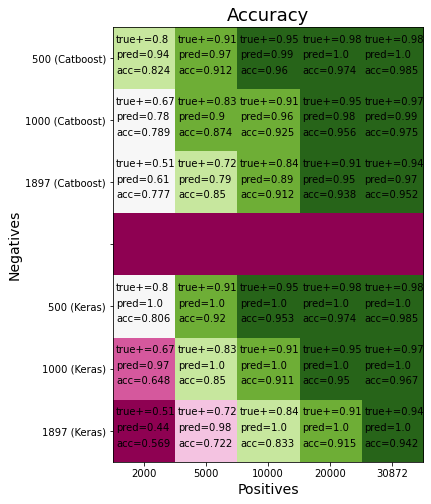

In [54]:


cmap = np.concatenate([
    catboost_scores,
    np.full((1, len(positive_steps)), min(catboost_scores.min(), keras_scores.min())),
    keras_scores
])
plt.figure(figsize=(10, 8))
plt.title(f'Accuracy', fontsize=18)
plt.imshow(cmap, cmap=plt.get_cmap("PiYG", 7))
plt.xlabel('Positives', fontsize=14)
plt.ylabel('Negatives', fontsize=14)
plt.xticks(range(len(positive_steps)), positive_steps)
plt.yticks(
    range(len(negative_steps)*2+1),
    [f'{x} (Catboost)' for x in negative_steps] + [''] + [f'{x} (Keras)' for x in negative_steps]
)
for i in range(len(negative_steps)):
    for j in range(len(positive_steps)):
        plt.text(j-0.45, i-0.25, f'true+={round(positive_steps[j] / (positive_steps[j] + negative_steps[i]), 2)}')
        plt.text(j-0.45, i, f'pred={round(catboost_means[i, j], 2)}')
        plt.text(j-0.45, i+0.25, f'acc={round(catboost_scores[i, j], 3)}')
        plt.text(j-0.45, i-0.25 + len(negative_steps) + 1, f'true+={round(positive_steps[j] / (positive_steps[j] + negative_steps[i]), 2)}')
        plt.text(j-0.45, i + len(negative_steps) + 1, f'pred={round(keras_means[i, j], 2)}')
        plt.text(j-0.45, i+0.25 + len(negative_steps) + 1, f'acc={round(keras_scores[i, j], 3)}')

## Catboost (plain)

In [ ]:
train_df, _ = datasets.amazon() # nice datasets with categorical features only :D
train_df = (
    pd
    .concat([train_df[train_df.ACTION == 1][:5000], train_df[train_df.ACTION == 0]])
    .sample(frac=1)
    .reset_index(drop=True)
)
y = train_df['ACTION']
X = train_df.drop(columns='ACTION') # or X = train_df.drop('ACTION', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [ ]:
condition = True # here we specify what condition should be satisfied only by the names of categorical features
cat_features_names = [col for col in X.columns if condition]
cat_features = [X.columns.get_loc(col) for col in cat_features_names]

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'early_stopping_rounds': 200,
          'verbose': False,  # 200, # output to stdout info about training process every 200 iterations
         }
cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    use_best_model=True,
    plot=False,
)

## Keras (plain)

In [ ]:
train_df, _ = datasets.amazon()
y = train_df['ACTION']
X = train_df.drop(columns='ACTION') # or X = train_df.drop('ACTION', axis=1)

# pd.get_dummies(X_train, columns=X_train.columns).shape
for col in X.columns:
    X[col] = (X[col] - X[col].min()) / (X[col].max() - X[col].min())

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10)

test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=2)
print('\nTest accuracy:', test_acc)


In [ ]:
model.predict(X_train).mean()

In [ ]:
y = train_df['ACTION']
X = train_df.drop(columns='ACTION') # or X = train_df.drop('ACTION', axis=1)

# pd.get_dummies(X_train, columns=X_train.columns).shape
for col in X.columns:
    X[col] = (X[col] - X[col].min()) / (X[col].max() - X[col].min())

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10)

test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=2)
print('\nTest accuracy:', test_acc)


In [ ]:
X.nunique()